## PyTorchを使ってLSTMで文章分類を実装

#### データ準備
livedoorニュースコーパスの「ldcc-20140209.tar.gz」データをダウンロードします。
https://www.rondhuit.com/download.html

#### データフレーム作成

In [1]:
%load_ext lab_black

In [2]:
import os
from glob import glob
import pandas as pd
import linecache

# カテゴリを配列で取得
categories = [name for name in os.listdir("text") if os.path.isdir("text/" + name)]
print(categories)

['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


In [3]:
datasets = pd.DataFrame(columns=["title", "category"])
for cat in categories:
    path = "text/" + cat + "/*.txt"
    files = glob(path)
    for text_name in files:
        title = linecache.getline(text_name, 3)
        s = pd.Series([title, cat], index=datasets.columns)
        datasets = datasets.append(s, ignore_index=True)

# データフレームシャッフル
datasets = datasets.sample(frac=1).reset_index(drop=True)
datasets.head()

,title,category
0,女子力を下げる！？ ブラトップのメリット・デメリット\n,dokujo-tsushin
1,60歳のリーアム・ニーソンが大自然に挑む！ 全米初登場1位を獲得した話題作の特別映像が公開\n,movie-enter
2,清水エスパルス、ラフプレー連発の韓国チームとの試合打ち切り\n,sports-watch
3,【週末映画まとめ読み】川口春奈の学校の呪いか、怪奇現象が撮影スタッフを襲う\n,movie-enter
4,応援する？ ムカつく？ あなたの近くの社内恋愛\n,dokujo-tsushin


#### インプットデータの前処理

In [4]:
import torch
import torch.nn as nn

# 以下の宣言で行が単語ベクトル、列が単語のインデックスのマトリクスを生成してる感じ
embeds = nn.Embedding(10, 6)  # (Embedding(単語の合計数, ベクトル次元数))

# ３行目の要素を取り出したいならば
w1 = torch.tensor([2])
print(embeds(w1))
# tensor([[-1.5947, -0.8387,  0.7669, -0.9644, -0.7902,  2.7167]],
#        grad_fn=<EmbeddingBackward>)

# 3行目、5行目、１０行目の要素を取り出したいならば、
w2 = torch.tensor([2, 4, 9])
print(embeds(w2))

tensor([[-0.0034, -1.0937, -0.8714, -0.6852, -1.8119, -1.0698]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-0.0034, -1.0937, -0.8714, -0.6852, -1.8119, -1.0698],
        [-1.0718, -1.6312, -1.0900,  0.2803,  0.5652,  0.3648],
        [ 1.5000,  0.5839, -1.7280,  0.8511, -0.1485,  0.2626]],
       grad_fn=<EmbeddingBackward0>)


In [5]:
import MeCab
import re
import torch

tagger = MeCab.Tagger("-Owakati")


def make_wakati(sentence):
    # MeCabで分かち書き
    sentence = tagger.parse(sentence)
    # 半角全角英数字除去
    sentence = re.sub(r"[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+", " ", sentence)
    # 記号もろもろ除去
    sentence = re.sub(
        r"[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+",
        "",
        sentence,
    )
    # スペースで区切って形態素の配列へ
    wakati = sentence.split(" ")
    # 空の要素は削除
    wakati = list(filter(("").__ne__, wakati))
    return wakati


# テスト
test = "【人工知能】は「人間」の仕事を奪った"
print(make_wakati(test))

['人工', '知能', 'は', '人間', 'の', '仕事', 'を', '奪っ', 'た']


In [6]:
# 単語ID辞書を作成する
word2index = {}
for title in datasets["title"]:
    wakati = make_wakati(title)
    for word in wakati:
        if word in word2index:
            continue
        word2index[word] = len(word2index)
print("vocab size : ", len(word2index))

# 文章を単語IDの系列データに変換
# PyTorchのLSTMのインプットになるデータなので、もちろんtensor型で
def sentence2index(sentence):
    wakati = make_wakati(sentence)
    return torch.tensor([word2index[w] for w in wakati], dtype=torch.long)


# テスト
test = "例のあのメニューも！ニコニコ超会議のフードコートメニュー14種類紹介（前半）"
print(sentence2index(test))

vocab size :  12943
tensor([11146,     5,   510,  1791,    87,   455,   579,   117,     5,  6609,
         9441,  1791,   139,   226,  8867])


In [7]:
# 全単語数を取得
VOCAB_SIZE = len(word2index)
# 単語のベクトル数
EMBEDDING_DIM = 10
test = "ユージの前に立ちはだかったJOY「僕はAKBの高橋みなみを守る」"
# 単語IDの系列データに変換
inputs = sentence2index(test)
# 各単語のベクトルをまとめて取得
embeds = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
sentence_matrix = embeds(inputs)
print(sentence_matrix.size())
print(sentence_matrix)

torch.Size([13, 10])
tensor([[ 1.2924,  1.0049, -0.4235, -0.3145, -0.2015,  0.2303, -1.5611,  0.7944,
         -1.5076, -0.8984],
        [ 2.7855,  1.5174, -1.6479, -0.6083,  1.1645,  0.0814, -0.4043, -0.9885,
          0.3231,  0.0576],
        [-0.2359,  0.6628, -0.7361, -1.0698, -0.0396, -0.6841, -0.7214, -1.3837,
         -0.1436,  1.3037],
        [-0.2570, -0.7394, -1.4081,  0.1961, -0.3433,  0.0773,  1.6191,  2.7852,
         -1.3463, -0.2776],
        [ 0.9059, -1.1631, -0.6054,  2.1713,  0.2681,  1.3946,  1.3794, -1.0091,
         -1.4485,  0.3529],
        [ 0.6158,  0.2263,  2.4530,  1.4154, -0.3832,  0.8459,  0.8830,  1.0365,
          0.6138, -1.1633],
        [ 0.7098,  1.5520,  1.6125,  0.2795,  1.0094, -2.2304, -0.5424,  1.6241,
          0.3676, -0.0075],
        [-1.5199, -1.4179, -1.1198, -1.3027,  0.4719, -1.0985, -0.6489,  0.7052,
         -0.1862,  1.9341],
        [ 2.7855,  1.5174, -1.6479, -0.6083,  1.1645,  0.0814, -0.4043, -0.9885,
          0.3231,  0.0576]

In [8]:
sentence_matrix.view(len(sentence_matrix), 1, -1).size()

torch.Size([13, 1, 10])

#### モデル定義

In [9]:
VOCAB_SIZE = len(word2index)
EMBEDDING_DIM = 10
HIDDEN_DIM = 128
embeds = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM)
s1 = "震災をうけて感じた、大切だと思ったこと"
print(make_wakati(s1))

['震災', 'を', 'うけ', 'て', '感じ', 'た', '大切', 'だ', 'と', '思っ', 'た', 'こと']


In [10]:
inputs1 = sentence2index(s1)
emb1 = embeds(inputs1)
lstm_inputs1 = emb1.view(len(inputs1), 1, -1)
out1, out2 = lstm(lstm_inputs1)
print(out1)
print(out2)

tensor([[[ 0.0128,  0.0267,  0.0776,  ..., -0.0112,  0.0140,  0.0113]],

        [[-0.0264,  0.0674,  0.1119,  ..., -0.0416, -0.0032,  0.0505]],

        [[-0.0053,  0.0437,  0.1291,  ..., -0.0072,  0.0328, -0.0062]],

        ...,

        [[ 0.0551,  0.0038,  0.0182,  ...,  0.0249,  0.0209, -0.0449]],

        [[ 0.1119,  0.0309, -0.0194,  ..., -0.0072, -0.0141,  0.0214]],

        [[ 0.1313,  0.0005,  0.0278,  ...,  0.0137,  0.0589,  0.0211]]],
       grad_fn=<StackBackward0>)
(tensor([[[ 1.3127e-01,  4.7330e-04,  2.7796e-02, -7.9767e-02,  5.1947e-02,
          -4.5127e-02, -6.4936e-02,  8.7204e-02, -3.8702e-03, -3.8706e-02,
          -6.3807e-02,  6.5902e-02, -2.4949e-02,  8.3646e-02, -6.3064e-02,
          -1.0602e-01,  3.8388e-05,  6.8999e-02,  4.0204e-02, -8.6478e-03,
          -2.7997e-02,  5.8894e-02,  5.8136e-02,  5.6753e-02, -9.4914e-02,
           4.6531e-03,  7.7826e-02, -3.4170e-02, -7.5847e-02,  3.3081e-02,
           4.5665e-02,  6.9231e-02,  5.7566e-02, -9.7086e-03,  4

In [11]:
# nn.Moduleを継承して新しいクラスを作る。決まり文句
class LSTMClassifier(nn.Module):
    # モデルで使う各ネットワークをコンストラクタで定義
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
        self.hidden_dim = hidden_dim
        # インプットの単語をベクトル化するために使う
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax(dim=1)

    # 順伝播処理はforward関数に記載
    def forward(self, sentence):
        # 文章内の各単語をベクトル化して出力。2次元のテンソル
        embeds = self.word_embeddings(sentence)
        # 2次元テンソルをLSTMに食わせられる様にviewで３次元テンソルにした上でLSTMへ流す。
        # 上記で説明した様にmany to oneのタスクを解きたいので、第二戻り値だけ使う。
        _, lstm_out = self.lstm(embeds.view(len(sentence), 1, -1))
        # lstm_out[0]は３次元テンソルになってしまっているので2次元に調整して全結合。
        tag_space = self.hidden2tag(lstm_out[0].view(-1, self.hidden_dim))
        # softmaxに食わせて、確率として表現
        tag_scores = self.softmax(tag_space)
        return tag_scores

#### 正解ラベルの変換

In [12]:
category2index = {}
for cat in categories:
    if cat in category2index:
        continue
    category2index[cat] = len(category2index)
print(category2index)


def category2tensor(cat):
    return torch.tensor([category2index[cat]], dtype=torch.long)


print(category2tensor("it-life-hack"))

{'dokujo-tsushin': 0, 'it-life-hack': 1, 'kaden-channel': 2, 'livedoor-homme': 3, 'movie-enter': 4, 'peachy': 5, 'smax': 6, 'sports-watch': 7, 'topic-news': 8}
tensor([1])


#### 学習

In [13]:
from sklearn.model_selection import train_test_split
import torch.optim as optim

# 元データを7:3に分ける（7->学習、3->テスト）
traindata, testdata = train_test_split(datasets, train_size=0.7)

# 単語のベクトル次元数
EMBEDDING_DIM = 10
# 隠れ層の次元数
HIDDEN_DIM = 128
# データ全体の単語数
VOCAB_SIZE = len(word2index)
# 分類先のカテゴリの数
TAG_SIZE = len(categories)
# モデル宣言
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAG_SIZE)
# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
loss_function = nn.NLLLoss()
# 最適化の手法はSGDで。lossの減りに時間かかるけど、一旦はこれを使う。
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 各エポックの合計loss値を格納する
losses = []
# 10ループ回してみる。（バッチ化とかGPU使ってないので結構時間かかる...）
for epoch in range(10):
    all_loss = 0
    for title, cat in zip(traindata["title"], traindata["category"]):
        # モデルが持ってる勾配の情報をリセット
        model.zero_grad()
        # 文章を単語IDの系列に変換（modelに食わせられる形に変換）
        inputs = sentence2index(title)
        # 順伝播の結果を受け取る
        out = model(inputs)
        # 正解カテゴリをテンソル化
        answer = category2tensor(cat)
        # 正解とのlossを計算
        loss = loss_function(out, answer)
        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        # lossを集計
        all_loss += loss.item()
    losses.append(all_loss)
    print("epoch", epoch, "\t", "loss", all_loss)
print("done.")

epoch 0 	 loss 10927.646444737911
epoch 1 	 loss 10020.675048947334
epoch 2 	 loss 9456.020045340061
epoch 3 	 loss 8970.832570170984
epoch 4 	 loss 8431.61981849838
epoch 5 	 loss 7906.497477673693
epoch 6 	 loss 7426.976272659202
epoch 7 	 loss 6985.692273202003
epoch 8 	 loss 6570.234288050502
epoch 9 	 loss 6175.362874631945
done.


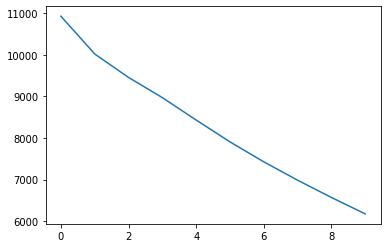

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(losses)

#### 予測精度確認

In [15]:
# テストデータの母数計算
test_num = len(testdata)
# 正解の件数
a = 0
# 勾配自動計算OFF
with torch.no_grad():
    for title, category in zip(testdata["title"], testdata["category"]):
        # テストデータの予測
        inputs = sentence2index(title)
        out = model(inputs)

        # outの一番大きい要素を予測結果をする
        _, predict = torch.max(out, 1)

        answer = category2tensor(category)
        if predict == answer:
            a += 1
print("predict : ", a / test_num)

predict :  0.5743334839584274


#### 過学習の確認

In [16]:
traindata_num = len(traindata)
a = 0
with torch.no_grad():
    for title, category in zip(traindata["title"], traindata["category"]):
        inputs = sentence2index(title)
        out = model(inputs)
        _, predict = torch.max(out, 1)
        answer = category2tensor(category)
        if predict == answer:
            a += 1
print("predict : ", a / traindata_num)

predict :  0.621537865582026


#### Fスコアの確認

In [17]:
import collections

# IDをカテゴリに戻す用
index2category = {}
for cat, idx in category2index.items():
    index2category[idx] = cat

# answer -> 正解ラベル、predict->LSTMの予測結果、exact->正解してたらO,間違っていたらX
predict_df = pd.DataFrame(columns=["answer", "predict", "exact"])

# 予測して結果を上のDFに格納
with torch.no_grad():
    for title, category in zip(testdata["title"], testdata["category"]):
        out = model(sentence2index(title))
        _, predict = torch.max(out, 1)
        answer = category2tensor(category)
        exact = "O" if predict.item() == answer.item() else "X"
        s = pd.Series([answer.item(), predict.item(), exact], index=predict_df.columns)
        predict_df = predict_df.append(s, ignore_index=True)

# Fスコア格納用のDF
fscore_df = pd.DataFrame(columns=["category", "all", "precison", "recall", "fscore"])

# 分類器が答えた各カテゴリの件数
prediction_count = collections.Counter(predict_df["predict"])
# 各カテゴリの総件数
answer_count = collections.Counter(predict_df["answer"])

# Fスコア求める
for i in range(9):
    all_count = answer_count[i]
    precision = (
        len(predict_df.query("predict == " + str(i) + ' and exact == "O"'))
        / prediction_count[i]
    )
    recall = (
        len(predict_df.query("answer == " + str(i) + ' and exact == "O"')) / all_count
    )
    fscore = 2 * precision * recall / (precision + recall)
    s = pd.Series(
        [
            index2category[i],
            all_count,
            round(precision, 2),
            round(recall, 2),
            round(fscore, 2),
        ],
        index=fscore_df.columns,
    )
    fscore_df = fscore_df.append(s, ignore_index=True)
print(fscore_df)

         category  all  precison  recall  fscore
0  dokujo-tsushin  242      0.49    0.64    0.55
1    it-life-hack  291      0.65    0.64    0.65
2   kaden-channel  245      0.90    0.74    0.81
3  livedoor-homme  157      0.59    0.48    0.53
4     movie-enter  267      0.41    0.40    0.41
5          peachy  244      0.50    0.46    0.48
6            smax  263      0.71    0.86    0.78
7    sports-watch  270      0.44    0.41    0.43
8      topic-news  234      0.52    0.49    0.50
